### RNN

Reference [Jon Krohn](https://github.com/the-deep-learners/TensorFlow-LiveLessons/blob/master/notebooks/rnn_in_keras.ipynb)

Basic RNN to classify positive / negative sentiment in IMDB dataset of 25000 reviews

In [1]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D
from keras.layers import SimpleRNN
# we need the simple RNN layer
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

Load Datasets

In [2]:
# vector-space embedding
n_dim = 64
n_unique_words = 10000
max_review_length = 100
# lower due to vanishing gradient over time (could be even lower)
# the RNN can't meaningfully look back far in sequence

pad_type = trunc_type = 'pre'
drop_embed = 0.2

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # removed n_words_to_skip

17464789/17464789 [==============================] - 2s 0us/step


Preprocess data

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

Set hyperparameters

In [5]:
# output directory name:
output_dir = 'weights_RNN'

# training:
epochs = 16
# RNN needs more epochs to train (vanishing gradients causes slower learning rate)
batch_size = 128

# RNN layer architecture
n_rnn = 256
drop_rnn = 0.2

# dense layer architecture
# n_dense = 256
# dropout = 0.2

Build Model

In [6]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))
model.add(SimpleRNN(n_rnn, dropout=drop_rnn))
# model.add(Dense(n_dense, activation='relu')) # typically don't see top dense layer in RNN NLP
# model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           640000    
                                                                 
 spatial_dropout1d (Spatial  (None, 100, 64)           0         
 Dropout1D)                                                      
                                                                 
 simple_rnn (SimpleRNN)      (None, 256)               82176     
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 722433 (2.76 MB)
Trainable params: 722433 (2.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compile model

In [8]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.keras")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Train the model - GPU!

In [10]:
# RNNs take longer to train so make sure you use the GPU
# training took 57s per epoch with no GPU

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/16
196/196 [==============================] - 52s 246ms/step - loss: 0.6992 - accuracy: 0.5146 - val_loss: 0.6806 - val_accuracy: 0.5699
Epoch 2/16
196/196 [==============================] - 32s 162ms/step - loss: 0.6602 - accuracy: 0.5889 - val_loss: 0.6560 - val_accuracy: 0.5962
Epoch 3/16
196/196 [==============================] - 32s 164ms/step - loss: 0.5921 - accuracy: 0.6727 - val_loss: 0.6347 - val_accuracy: 0.6301
Epoch 4/16
196/196 [==============================] - 30s 152ms/step - loss: 0.5904 - accuracy: 0.6845 - val_loss: 0.7165 - val_accuracy: 0.6391
Epoch 5/16
196/196 [==============================] - 29s 150ms/step - loss: 0.4992 - accuracy: 0.7542 - val_loss: 0.5854 - val_accuracy: 0.7106
Epoch 6/16
196/196 [==============================] - 28s 140ms/step - loss: 0.4610 - accuracy: 0.7840 - val_loss: 0.6588 - val_accuracy: 0.6768
Epoch 7/16
196/196 [==============================] - 28s 144ms/step - loss: 0.5000 - accuracy: 0.7487 - val_loss: 0.6106 - val_ac

Select the epoch with highest accuracy as the model to use for prediction

In [11]:
# load the epoch weight reference with highest validation accuracy

model.load_weights(output_dir+"/weights.07.keras") # zero-indexed

In [12]:
model.save("RNN_Model.keras")

In [13]:
y_hat = model.predict(x_valid)

782/782 [==============================] - 7s 9ms/step


Evaluate

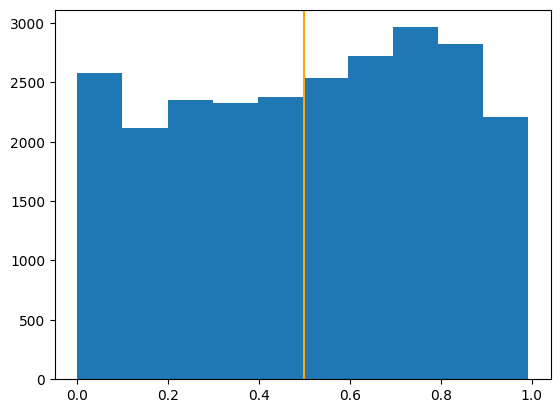

In [14]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')


In [15]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'74.74'

Here we only get ~ 77% accuracy in a binary classification...

Contrast with the 95%+ we saw with the CNN